## Import libraries

In [1]:
import pandas as pd
import numpy as np
import ruptures as rpt
import matplotlib.pyplot as plt
from einops import rearrange
from pathlib import Path
from circruptures import (
    get_bkps,
    estimate_var,
    distance_between_bkps,
    convert_bkps_to_distrib,
    get_approx,
)
import json
from joblib import Parallel, delayed
from scipy.stats import circmean, wasserstein_distance, circvar
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist, squareform
from itertools import combinations

In [ ]:
# set to True if you want to recompute all change points and distances.
# (this might take several hours)
RECOMPUTE_BKPS = False
RECOMPUTE_CLUSTERING = False

## Load data

In [3]:
data_path = Path("/home/truong/code/geodesic-change/data/data_1.pkl.ikwt0u")
df = pd.read_pickle(data_path)
# all_signals, shape (n_signals, n_samples, 2)
all_signals = rearrange(
    df.to_numpy(),
    "n_samples (n_signals n_dims) -> n_signals n_samples n_dims",
    n_dims=2,
)
all_signals = np.deg2rad(all_signals)

## Compute/load all change points

In [33]:
penalty_factor = 14_000
penalty_factor = 10_000
penalty_factor = 9_500
filename = f"{data_path.stem}_pen={penalty_factor}.bkps.json"

### If not computed, compute all change points

In [5]:
@delayed
def get_bkps_parallel(signal, penalty_factor):
    n_samples = signal.shape[0]
    variance = estimate_var(signal, n_segments=50)
    bkps = get_bkps(
        signal,
        penalty=penalty_factor * np.log(n_samples) * variance,
        return_approx=False,
        n_states=20,
    )
    return bkps.tolist()


if RECOMPUTE_BKPS:
    all_bkps = Parallel(n_jobs=-5)(
        get_bkps_parallel(signal, penalty_factor=penalty_factor)
        for signal in all_signals
    )

    # Save results
    with open(filename, "w") as f:
        json.dump(all_bkps, f, indent=4)

### If computed, simply load all change points

In [34]:
with open(filename, "r") as f:
    all_bkps = json.load(f)

## Plot one 2D signal

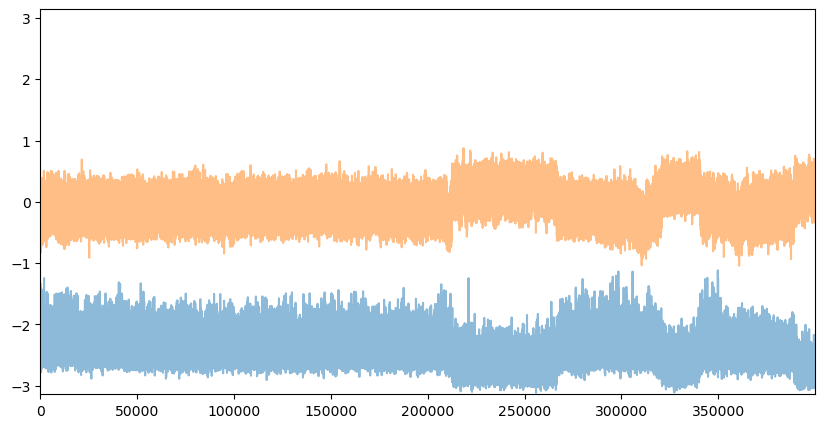

In [7]:
amino_acid = 161  # zero-based, contrary to the website
amino_acid = 71
amino_acid = 67
amino_acid = 160
amino_acid = 34
amino_acid = 35
amino_acid = 628
amino_acid = 393
amino_acid = 240
amino_acid = 412
signal = all_signals[amino_acid]  # shape (n_samples, 2)
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(signal, alpha=0.5)
ax.set_xmargin(0)
_ = ax.set_ylim(-np.pi, np.pi)

## Our method

1. Find discrete levels
2. Perform discrete change-point detection.

In [8]:
# 2. Perform discrete change-point detection.
n_samples = signal.shape[0]
bkps = all_bkps[amino_acid]
n_bkps = len(bkps) - 1
print(f"{ n_bkps = }")

 n_bkps = 5


In [ ]:
# # in case you want to recompute the change points
# penalty_factor = 14_000
# n_samples = signal.shape[0]
# variance = estimate_var(signal, n_segments=50)
# bkps = get_bkps(
#     signal,
#     penalty=penalty_factor * np.log(n_samples) * variance,
#     return_approx=False,
#     n_states=20,
# )

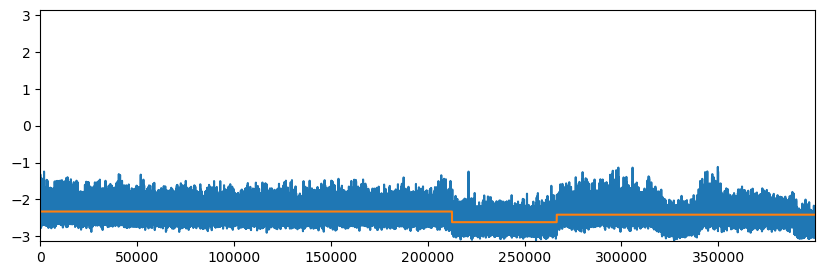

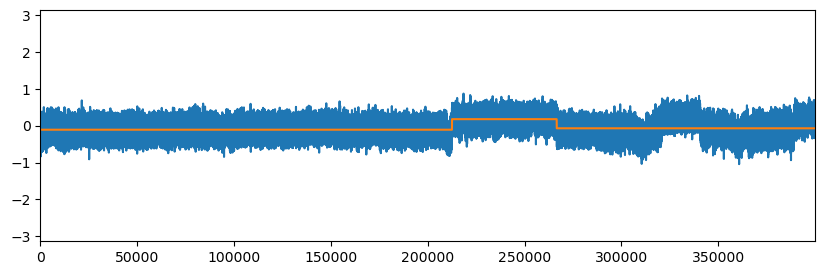

In [10]:
# Plot first dimension and its approximation
approx = get_approx(signal, bkps)
for dim in range(2):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.plot(signal[:, dim])
    ax.plot(approx[:, dim])
    ax.set_xmargin(0)
    _ = ax.set_ylim(-np.pi, np.pi)

## Compare two amino acids (two examples)

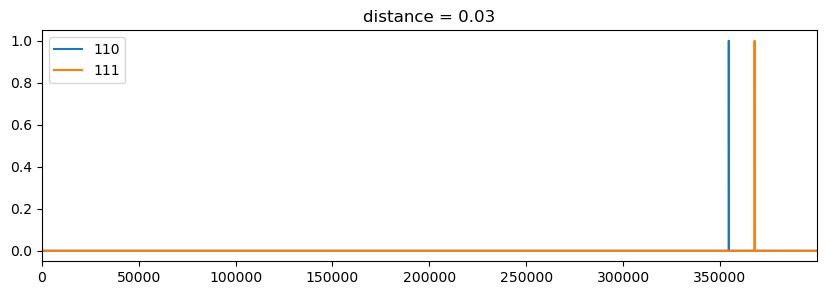

In [100]:
amino_acid1 = 110
signal1 = all_signals[amino_acid1]  # shape (n_samples, 2)
bkps1 = all_bkps[amino_acid1]
distrib1 = convert_bkps_to_distrib(signal1, bkps1)

amino_acid2 = 111
signal2 = all_signals[amino_acid2]  # shape (n_samples, 2)
bkps2 = all_bkps[amino_acid2]
distrib2 = convert_bkps_to_distrib(signal2, bkps2)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_xmargin(0)
ax.plot(distrib1, label=amino_acid1)
ax.plot(distrib2, label=amino_acid2)
plt.legend()

distance = distance_between_bkps(
    signal1=signal1, bkps1=bkps1, signal2=signal2, bkps2=bkps2
)
_ = ax.set_title(f"{distance = :.2f}")

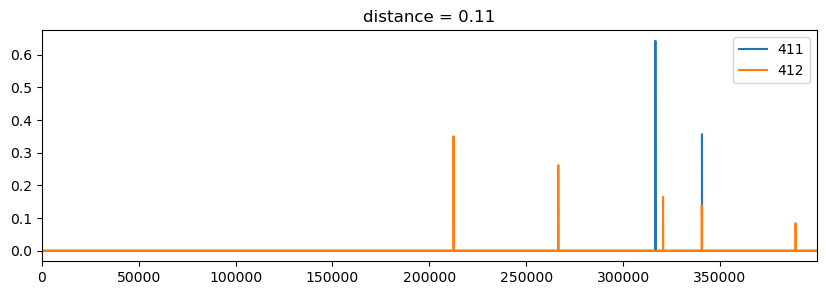

In [96]:
amino_acid1 = 411
signal1 = all_signals[amino_acid1]  # shape (n_samples, 2)
bkps1 = all_bkps[amino_acid1]
distrib1 = convert_bkps_to_distrib(signal1, bkps1)

amino_acid2 = 412
signal2 = all_signals[amino_acid2]  # shape (n_samples, 2)
bkps2 = all_bkps[amino_acid2]
distrib2 = convert_bkps_to_distrib(signal2, bkps2)

fig, ax = plt.subplots(figsize=(10, 3))
ax.set_xmargin(0)
ax.plot(distrib1, label=amino_acid1)
ax.plot(distrib2, label=amino_acid2)
plt.legend()

distance = distance_between_bkps(
    signal1=signal1, bkps1=bkps1, signal2=signal2, bkps2=bkps2
)
_ = ax.set_title(f"{distance = :.2f}")

## Clustering using our custom distance

In [25]:
keep_inds = [k for k, bkps in enumerate(all_bkps) if len(bkps) > 1]

In [36]:
filename = Path(f"all_distances_pen={penalty_factor}.npy")
if RECOMPUTE_CLUSTERING:
    get_distance_parallel = delayed(distance_between_bkps)

    all_distances = Parallel(prefer="threads", n_jobs=20)(
        [
            get_distance_parallel(
                all_signals[keep_inds[i]],
                all_bkps[keep_inds[i]],
                all_signals[keep_inds[j]],
                all_bkps[keep_inds[j]],
            )
            for i, j in combinations(range(len(keep_inds)), 2)
        ]
    )
    np.save(filename, np.array(all_distances))

In [45]:
# condensed distance matrix
distance_matrix = np.empty((len(keep_inds), len(keep_inds)))
all_distances = np.load(filename)
for (i, j), dist in zip(combinations(range(len(keep_inds)), 2), all_distances):
    distance_matrix[i, j] = dist
    distance_matrix[j, i] = dist
    distance_matrix[i, i] = 0
    distance_matrix[j, j] = 0
distance_matrix = squareform(distance_matrix)

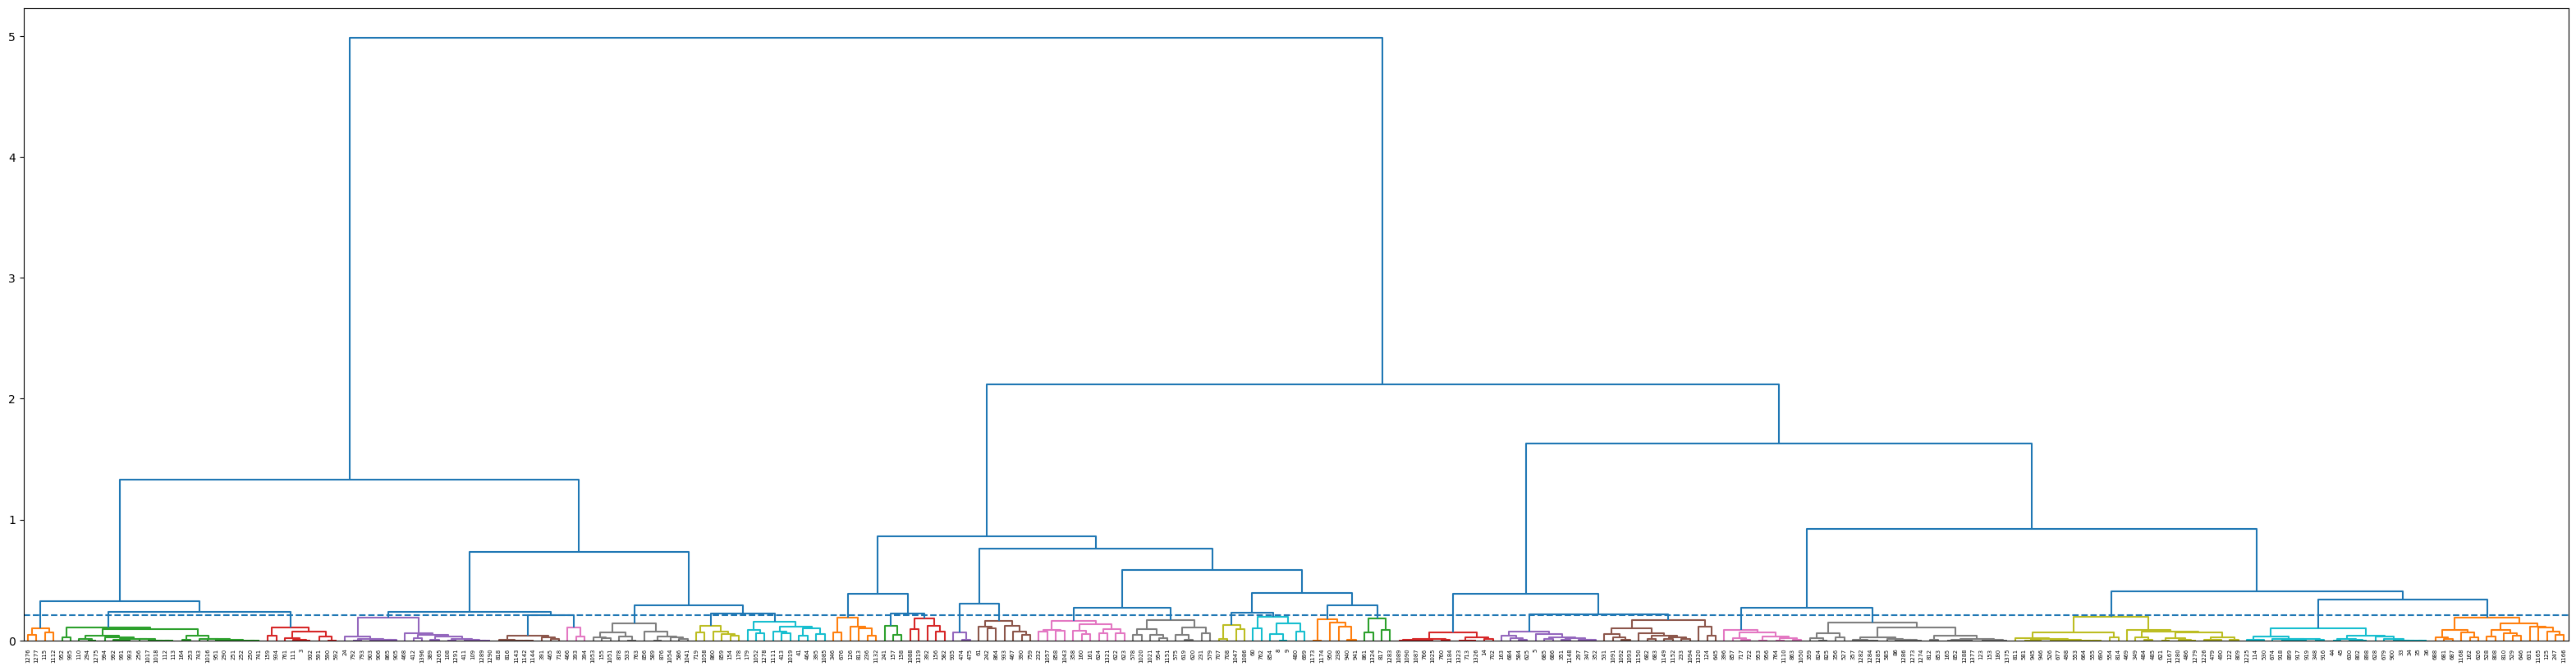

In [ ]:
# Compute linkage matrix using the 'Ward' criterion
linkage = hierarchy.ward(distance_matrix)
fig, ax = plt.subplots(figsize=(40, 10))
cut_threshold = 0.21  # CHANGE VALUE HERE TO CHANGE THE THRESHOLD
dendro = hierarchy.dendrogram(
    linkage,
    ax=ax,
    labels=np.array(keep_inds) + 1,
    color_threshold=cut_threshold,
    distance_sort=True,
)
ax.axhline(cut_threshold, ls="--")
plt.savefig(f"dendogram_pen={penalty_factor}.pdf", dpi=300)